In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn import cluster, tree, decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from kmodes.kprototypes import KPrototypes
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

# Download the dataset
# Source https://data.world/jfreex/e-commerce-users-of-a-french-c2c-fashion-store
fl = '2. Prepared Data/6M-0K-99K.users.dataset.public.csv'
data = pd.read_csv(fl)

# Preview data
data.head()

,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,civilityGenderId,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-7279641312655250028,user,Etats-Unis,en,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,us
1,-1456013578740053406,user,Allemagne,de,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,de
2,9006282053848196165,user,Suède,en,3,8,0,0,0,0.0,0,0,M,1,mr,True,False,True,True,689,3205,106.83,8.9,se
3,-7154634866120535654,user,Turquie,en,3,8,0,0,0,0.0,0,0,F,2,mrs,False,False,False,True,709,3205,106.83,8.9,tr
4,2858299215060733023,user,France,en,3,8,0,0,0,0.0,0,0,M,1,mr,True,False,True,True,709,3205,106.83,8.9,fr


In [2]:
# Drop columns with information that will not be used or is duplicated 
drop_columns = ['productsPassRate', 'civilityGenderId', 'civilityTitle', 'seniorityAsMonths', 'seniorityAsYears','countryCode']
data.drop(columns=drop_columns, inplace=True)
# Get the dimensionality of the dataset
print(data.shape)

(98913, 18)


In [3]:
# Split up numeric, categorical, and boolean columns 
print('Columns')
numeric_cols = data.select_dtypes([np.int64,np.float64]).columns.tolist()
print (f'Numeric: {len(numeric_cols)} \n{numeric_cols}')

categorical_cols = data.select_dtypes([np.object]).columns.tolist()
print (f'Categorical: {len(categorical_cols)} \n{categorical_cols}')

booleans_cols = data.select_dtypes([np.bool]).columns.tolist()
print (f'Boolean: {len(booleans_cols)} \n{booleans_cols}')

Columns
Numeric: 10 
['identifierHash', 'socialNbFollowers', 'socialNbFollows', 'socialProductsLiked', 'productsListed', 'productsSold', 'productsWished', 'productsBought', 'daysSinceLastLogin', 'seniority']
Categorical: 4 
['type', 'country', 'language', 'gender']
Boolean: 4 
['hasAnyApp', 'hasAndroidApp', 'hasIosApp', 'hasProfilePicture']


In [4]:
# Filter data of active users, who sold, bought, wished or liked products

###################################### FILTER ################################################

# List of columns related to user activity in selling of products
products = ['socialProductsLiked', 'productsListed', 'productsSold', 'productsWished', 'productsBought']
# Calculate sum across rows
data['productSum'] = data[products].sum(axis=1)

# Filter data of user who have any activity (sum > 0)
data = data[data['productSum'] > 0]

# Drop utility 'productSum' column
data.drop(columns='productSum', inplace=True)

# Reset index
data.reset_index(drop=True, inplace=True)

# Preview data
data.shape

(21639, 18)

In [5]:
# Translate the list of countries into English 
data['country'] = data['country'].replace({
     'Royaume-Uni':'UK', 'Danemark':'Denmark','Etats-Unis':'US', 'Allemagne':'Germany', 
     'Suisse':'Swiss','Suède':'Sweden','Australie':'Australia','Italie':'Italy', 'Espagne':'Spain', 
     'Finlande':'Finland','Belgique':'Belgium','Pays-Bas':'Netherlands', 'Autriche':'Austria', 
    'Russie':'Russia', 'Bulgarie':'Bulgaria', 'Chine':'China', 'Irlande': 'Ireland', 'Roumanie':'Romania'})

# Group users by country
countries=pd.DataFrame(data['country'].value_counts()).sort_values(by='country',ascending=False)
countries.rename(columns={'country':'users'}, inplace=True)
# Calculate % of total users by country
countries['users_%_total'] = round(countries['users']/countries['users'].sum(),3)*100

# Define countries as 'Other', if % of users is less then 1%
users_perc_lim = 1
other_countries = countries[countries['users_%_total']<users_perc_lim].index.tolist()
print(f'Other countries: {len(other_countries)}')
#print(other_countries)
data['country_short_list']=data['country'].apply(lambda x: 'Other' if x in other_countries else x)
countries_list = data['country_short_list'].unique().tolist()
print(f'Countries short list: {countries_list}')

# Change the boolean column type to integer
data[booleans_cols]=data[booleans_cols].astype(int)

# Duplicate columns
data['language_c']=data['language']
# Convert categorical variable into dummy/indicator variables
cat_features =['language', 'gender', 'country_short_list']
data = pd.get_dummies(data, columns=cat_features)

# Rename columns
data.rename(columns={'language_c': 'language'}, inplace=True)

# Save the preprocessed data to a csv file
file = '2. Prepared Data/classification_e-commerce_preprocessed_data.csv'
data.to_csv(file, index = False)
data.shape

Other countries: 114
Countries short list: ['UK', 'Denmark', 'US', 'Germany', 'Swiss', 'France', 'Other', 'Sweden', 'Canada', 'Australia', 'Italy', 'Spain', 'Belgium', 'Netherlands']


(21639, 38)

In [6]:
data.head()

,identifierHash,type,country,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsWished,productsBought,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,language,language_de,language_en,language_es,language_fr,language_it,gender_F,gender_M,country_short_list_Australia,country_short_list_Belgium,country_short_list_Canada,country_short_list_Denmark,country_short_list_France,country_short_list_Germany,country_short_list_Italy,country_short_list_Netherlands,country_short_list_Other,country_short_list_Spain,country_short_list_Sweden,country_short_list_Swiss,country_short_list_UK,country_short_list_US
0,-7877915015908472168,user,UK,3,8,4,0,0,0,0,0,0,0,1,591,3205,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-8231936648814680895,user,Denmark,3,8,370,0,0,1,0,0,0,0,1,42,3205,en,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,5663923945758514393,user,US,3,8,1,0,0,0,0,0,0,0,1,32,3205,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,-3483039296670050121,user,Germany,3,8,27,0,0,0,0,1,0,1,1,669,3205,de,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,3451396970677435825,user,Swiss,3,8,0,0,0,9,0,1,1,0,1,463,3205,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


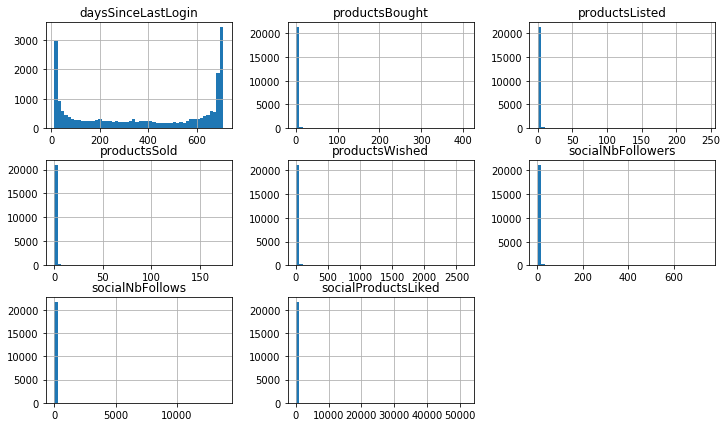

In [7]:
data_num = data[numeric_cols].drop(['identifierHash', 'seniority'], axis=1)
data_num.hist(figsize=(12,7), bins =50)
plt.show()

In [8]:
data[data['productsWished']>1000]

,identifierHash,type,country,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsWished,productsBought,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,language,language_de,language_en,language_es,language_fr,language_it,gender_F,gender_M,country_short_list_Australia,country_short_list_Belgium,country_short_list_Canada,country_short_list_Denmark,country_short_list_France,country_short_list_Germany,country_short_list_Italy,country_short_list_Netherlands,country_short_list_Other,country_short_list_Spain,country_short_list_Sweden,country_short_list_Swiss,country_short_list_UK,country_short_list_US
1211,1450851698857145434,user,Germany,48,16,599,22,82,1016,32,1,0,1,0,11,3203,de,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4865,-4630794638135820237,user,Portugal,36,60,1078,0,0,2635,2,1,0,1,1,12,3205,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4891,89484519148157873,user,Germany,18,9,5109,0,0,1086,14,1,1,0,1,15,3205,de,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
10975,3718185418791028367,user,Italy,744,13764,51671,0,104,1842,0,1,0,1,0,14,3195,it,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11580,8805241742068118138,user,Bulgaria,40,174,13,0,5,1900,41,1,1,1,1,112,3195,en,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
12245,-2755017794484900192,user,France,16,10,33,0,0,1225,0,1,1,0,1,14,2859,fr,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
13463,-8474291847456845496,user,UK,19,13,1929,0,0,1820,35,0,0,0,1,12,2858,en,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
13938,-4263154094239476485,user,Spain,36,19,5598,2,4,1295,18,0,0,0,0,12,2857,es,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
15984,-60934888240031989,user,Denmark,37,12,1031,1,0,1622,14,1,0,1,0,44,2856,en,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
16289,4544236993054741742,user,Italy,48,28,346,3,19,1075,54,1,0,1,0,11,2856,it,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [9]:
data_num = data[numeric_cols].drop(['identifierHash', 'seniority'], axis=1)
data_num.head()

outliers_filter = (data['socialNbFollows']>1000) | (data['socialProductsLiked']>5000) | (data['productsWished']>1000)
outliers_index = data[outliers_filter].index

#print(f'Drop outliers: {len(outliers_index)}')
#data.drop(outliers_index, inplace=True)

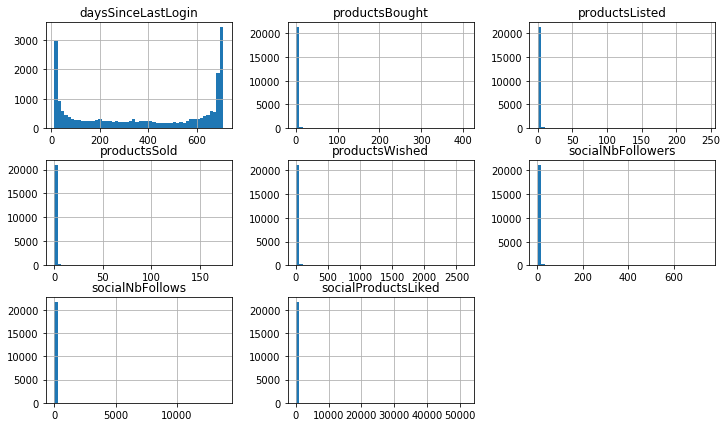

In [10]:
data_num = data[numeric_cols].drop(['identifierHash', 'seniority'], axis=1)
data_num.hist(figsize=(12,7), bins =50)
plt.show()

In [11]:
data.columns

Index(['identifierHash', 'type', 'country', 'socialNbFollowers',
       'socialNbFollows', 'socialProductsLiked', 'productsListed',
       'productsSold', 'productsWished', 'productsBought', 'hasAnyApp',
       'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'daysSinceLastLogin',
       'seniority', 'language', 'language_de', 'language_en', 'language_es',
       'language_fr', 'language_it', 'gender_F', 'gender_M',
       'country_short_list_Australia', 'country_short_list_Belgium',
       'country_short_list_Canada', 'country_short_list_Denmark',
       'country_short_list_France', 'country_short_list_Germany',
       'country_short_list_Italy', 'country_short_list_Netherlands',
       'country_short_list_Other', 'country_short_list_Spain',
       'country_short_list_Sweden', 'country_short_list_Swiss',
       'country_short_list_UK', 'country_short_list_US'],
      dtype='object')

In [12]:
features = ['productsListed', 'productsSold', 'productsBought',
           'socialProductsLiked','productsWished', 'socialNbFollowers','socialNbFollows', 
            'daysSinceLastLogin']
            #,'hasAnyApp','hasProfilePicture',
            #'language_de', 'language_en', 'language_es', 'language_fr', 'language_it']

# CLUSTERING

(21639, 38)


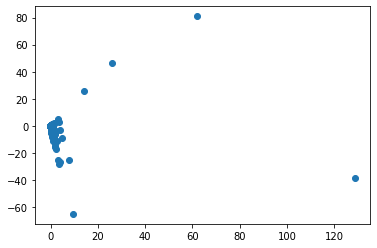

In [13]:
# Set up the data
df=data.copy()
df= df[features]

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df[features] = RobustScaler().fit_transform(df[features])

# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(df[features])

print(data.shape)
plt.scatter(df_pca[:,0],df_pca[:,1])
plt.show()  

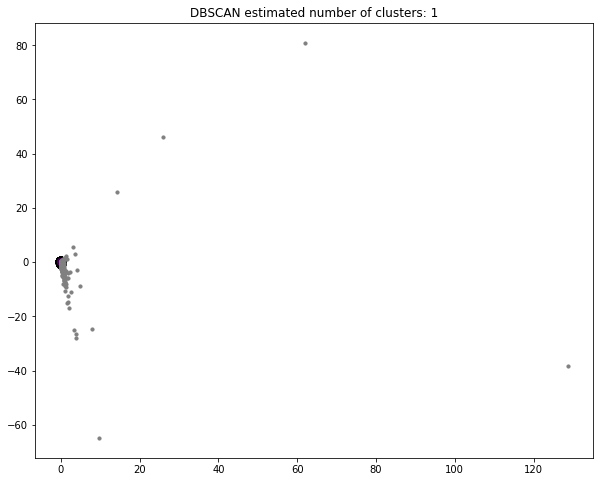

DBSCAN:
Estimated number of clusters: 1 Silhoette Coefficient: 0.8403345647065456
 0    20112
-1     1527
Name: labels, dtype: int64


In [14]:
# DBSCAN
df=data.copy()
df= df[features]

# Scale the data using RobustScaler as it is based on percentiles and not influenced by outliers
df[features] = RobustScaler().fit_transform(df[features])

# Instantiate a DBSCAN Model, fit the model
dbscan = DBSCAN(eps=5.43, min_samples = 9, metric='manhattan').fit(df[features])
# Store labels formed by the DBSCAN
labels = dbscan.labels_
# Set clasters to the DataFrame
df['labels'] = labels

df['x']=df_pca[:,0]
df['y']=df_pca[:,1]

# Number of clusters
n_clusters_ = len(set(labels)) - ( 1 if -1 in labels else 0)

# Plot the result
plt.figure(figsize=(10,8))

clust = df['labels']!=-1
data_cl = df.loc[clust]
plt.scatter(data_cl['x'], data_cl['y'], c=data_cl['labels'], edgecolors='k', s=84)

outl = df['labels']==-1
data_outl = df.loc[outl]
plt.scatter(data_outl['x'], data_outl['y'], c='grey', edgecolors='grey', s=10)

plt.title('DBSCAN estimated number of clusters: %d' % n_clusters_)
plt.show()

print('DBSCAN:')
# Silhouette Score
sil_coeff= silhouette_score(df[features], labels, metric='manhattan')
print(f'Estimated number of clusters: {n_clusters_} Silhoette Coefficient: {sil_coeff}')
print(df['labels'].value_counts())

In [15]:
df_copy=data.copy()
# Combine DataFrames in result DataFrame
result_dbs = pd.concat([df_copy, df['labels']], axis=1)
result_dbs.rename(columns={'labels':'DBSCAN'}, inplace=True)
result = result_dbs.drop('identifierHash', axis=1) 

In [16]:
#result[result['DBSCAN']==-1].describe()

In [17]:
df_selling = df[['productsBought','productsListed','productsSold','labels']]
df_selling[df_selling['labels']==0].describe()

,productsBought,productsListed,productsSold,labels
count,20112.000000,20112.000000,20112.000000,20112.0
mean,0.373856,0.115553,0.159109,0.0
std,1.021814,0.648873,0.842616,0.0
min,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.000000,0.0
max,19.000000,13.000000,15.000000,0.0


In [18]:
df_selling[df_selling['labels']==-1].describe()

,productsBought,productsListed,productsSold,labels
count,1527.000000,1527.000000,1527.000000,1527.0
mean,6.212836,4.521938,5.780616,-1.0
std,17.328108,15.710291,15.844417,0.0
min,0.000000,0.000000,0.000000,-1.0
25%,0.000000,0.000000,0.000000,-1.0
50%,2.000000,0.000000,0.000000,-1.0
75%,6.000000,3.000000,4.000000,-1.0
max,405.000000,244.000000,174.000000,-1.0


In [19]:
#df[df['labels']==0].describe()

In [20]:
#df[df['labels']==-1].describe()

In [21]:
# Save the DBSCAN clusters data to a csv file
#file = '5. Insights/classification_e-commerce_DBSCAN_clusters.csv'
#data.to_csv(file, index = False)

In [22]:
df.head()

,productsListed,productsSold,productsBought,socialProductsLiked,productsWished,socialNbFollowers,socialNbFollows,daysSinceLastLogin,labels,x,y
0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.320405,0,-0.025664,0.071563
1,0.0,0.0,0.0,61.500000,0.5,0.0,0.0,-0.605396,-1,0.193635,-1.412918
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-0.622260,0,-0.027459,0.083668
3,0.0,0.0,0.0,4.333333,0.0,0.0,0.0,0.451939,0,-0.011900,-0.021457
4,0.0,0.0,0.0,-0.166667,4.5,0.0,0.0,0.104553,0,-0.025723,0.050430


In [23]:
data_new = df[df['labels']!=-1]
print(data_new.shape)

(20112, 11)


In [24]:
#data_new = data_new[features]
X = data_new[features]
X.head()

,productsListed,productsSold,productsBought,socialProductsLiked,productsWished,socialNbFollowers,socialNbFollows,daysSinceLastLogin
0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.320405
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-0.622260
3,0.0,0.0,0.0,4.333333,0.0,0.0,0.0,0.451939
4,0.0,0.0,0.0,-0.166667,4.5,0.0,0.0,0.104553
5,0.0,0.0,0.0,0.166667,0.5,0.0,0.0,0.234401


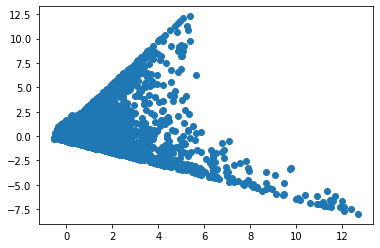

In [25]:
# Principal component analysis for visualization
pca = PCA(n_components=2, whiten=True)
df_pca = pca.fit_transform(X)

plt.scatter(df_pca[:,0],df_pca[:,1])
plt.show()

In [26]:
# Silhouette method
#X = data_new
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    labels = kmeans.labels_
    sil_coeff = silhouette_score(X, labels, metric='euclidean')
    print(f'For n_clusters={n_cluster}, The Silhouette Coefficient: {sil_coeff}') 

For n_clusters=2, The Silhouette Coefficient: 0.7183206863787892
For n_clusters=3, The Silhouette Coefficient: 0.7272960640459433
For n_clusters=4, The Silhouette Coefficient: 0.7331407119834741
For n_clusters=5, The Silhouette Coefficient: 0.6153315094264975
For n_clusters=6, The Silhouette Coefficient: 0.6044005888336234
For n_clusters=7, The Silhouette Coefficient: 0.6060689257527986
For n_clusters=8, The Silhouette Coefficient: 0.5547074313401181
For n_clusters=9, The Silhouette Coefficient: 0.46902669218425225
For n_clusters=10, The Silhouette Coefficient: 0.46853337152232566


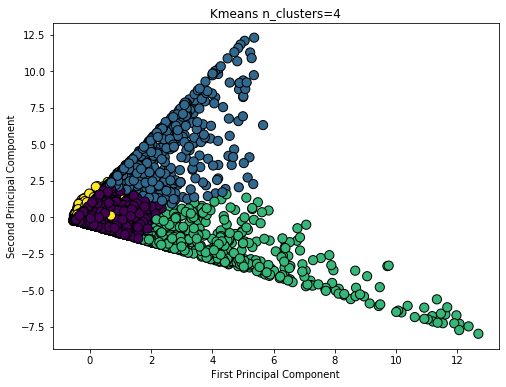

Kmeans:
For n_clusters=4, The Silhouette Coefficient: 0.7331407119834741


In [28]:
# KMeans with 4 clusters 
km = cluster.KMeans(n_clusters=4, max_iter=300, random_state=None)
labels = km.fit_predict(X)
n_clusters = km.n_clusters

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'Kmeans n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('Kmeans:')
# Silhouette Score
sil_coeff = silhouette_score(X, labels, metric='euclidean')
print(f'For n_clusters={n_clusters}, The Silhouette Coefficient: {sil_coeff}')

In [29]:
# Agglomerative Clustering
df=X.copy()
df= df[features]
df.head()

,productsListed,productsSold,productsBought,socialProductsLiked,productsWished,socialNbFollowers,socialNbFollows,daysSinceLastLogin
0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.320405
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-0.622260
3,0.0,0.0,0.0,4.333333,0.0,0.0,0.0,0.451939
4,0.0,0.0,0.0,-0.166667,4.5,0.0,0.0,0.104553
5,0.0,0.0,0.0,0.166667,0.5,0.0,0.0,0.234401


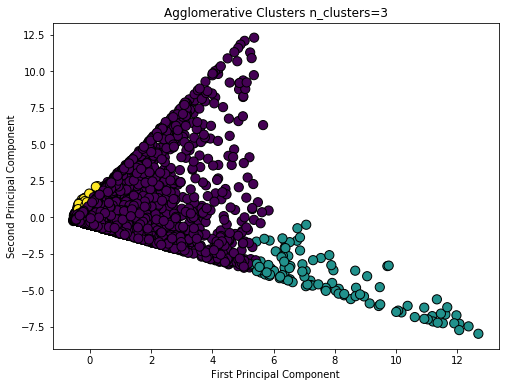

Agglomerative Clustering:
For n_clusters=3, The Silhouette Coefficient: 0.7649711761691244


In [33]:
# Agglomerative Clustering

df=X.copy()
df= df[features]

aggl = AgglomerativeClustering(n_clusters=3, affinity='manhattan', linkage='average').fit(df)
labels = aggl.labels_
n_clusters = aggl.n_clusters_

# Plot the result
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0],df_pca[:,1], c=labels, edgecolors='k', s=84)

plt.title(f'Agglomerative Clusters n_clusters={n_clusters}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

print('Agglomerative Clustering:')
# Silhouette Score
sil_coeff = silhouette_score(df, labels, metric='manhattan')
print(f'For n_clusters={n_clusters}, The Silhouette Coefficient: {sil_coeff}')


# Set clasters to the DataFrame
df['labels'] = labels
df['x']=df_pca[:,0]
df['y']=df_pca[:,1]

In [31]:
# Silhouette method
for n_cluster in range(2, 6):
    aggl = AgglomerativeClustering(n_clusters=n_cluster, affinity='manhattan', linkage='average').fit(df)
    labels = aggl.labels_
    sil_coeff = silhouette_score(df, labels, metric='manhattan')
    print(f'For n_clusters={n_cluster}, The Silhouette Coefficient: {sil_coeff}') 

For n_clusters=2, The Silhouette Coefficient: 0.851792261001288
For n_clusters=3, The Silhouette Coefficient: 0.8249378454582708
For n_clusters=4, The Silhouette Coefficient: 0.751434184190476
For n_clusters=5, The Silhouette Coefficient: 0.7412930647356751


In [32]:
# Silhouette method
for n_cluster in range(2, 6):
    aggl = AgglomerativeClustering(n_clusters=n_cluster, affinity='manhattan', linkage='complete').fit(df)
    labels = aggl.labels_
    sil_coeff = silhouette_score(df, labels, metric='manhattan')
    print(f'For n_clusters={n_cluster}, The Silhouette Coefficient: {sil_coeff}')  

For n_clusters=2, The Silhouette Coefficient: 0.6614949048968978
For n_clusters=3, The Silhouette Coefficient: 0.6832284751438082
For n_clusters=4, The Silhouette Coefficient: 0.6426014412284007
For n_clusters=5, The Silhouette Coefficient: 0.6491328436641961
